In [531]:
ds_path='../datasets/riceClassification.csv'

In [532]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [533]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

device

'cpu'

In [534]:
rice_ds = pd.read_csv(ds_path)

original_ds = rice_ds.copy()

In [535]:
rice_ds.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [536]:
rice_ds.shape, rice_ds.isnull().sum()

((18185, 12),
 id                 0
 Area               0
 MajorAxisLength    0
 MinorAxisLength    0
 Eccentricity       0
 ConvexArea         0
 EquivDiameter      0
 Extent             0
 Perimeter          0
 Roundness          0
 AspectRation       0
 Class              0
 dtype: int64)

In [537]:
for column in rice_ds.columns:
    rice_ds[column] = rice_ds[column] / rice_ds[column].abs().max()

rice_ds.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.000055,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.000110,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.000165,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.000220,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.000275,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [538]:
rice_ds.value_counts("Class")

Class
1.0    9985
0.0    8200
Name: count, dtype: int64

In [539]:
X = np.array(rice_ds.iloc[:, :-1])
Y = np.array(rice_ds.iloc[:, -1])

In [540]:
X.shape, Y.shape

((18185, 11), (18185,))

In [541]:
X_train, X_test, Y_train, Y_test=train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

X_test, X_val, Y_test, Y_val=train_test_split(
    X_test,
    Y_test,
    test_size=0.5,
    random_state=42,
    stratify=Y_test
)

In [542]:
X.shape, X_train.shape, X_test.shape, X_val.shape

((18185, 11), (14548, 11), (1818, 11), (1819, 11))

In [543]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [544]:
training_data = dataset(X_train, Y_train)
testing_data = dataset(X_test, Y_test)
validating_data = dataset(X_val, Y_val)

In [545]:
BATCH_SIZE=32
EPOCHS=5
HIDDEN_NEURONS=10
LR=1e-3

In [546]:
training_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
testing_data_loader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)
validating_data_loader = DataLoader(validating_data, batch_size=BATCH_SIZE, shuffle=True)

In [547]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_neurons):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_neurons)
        self.linear = nn.Linear(hidden_neurons, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [548]:
model = MyModel(X.shape[1], HIDDEN_NEURONS)

In [549]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [550]:
total_train_loss_plot = []
total_train_acc_plot = []
total_validation_loss_plot = []
total_validation_acc_plot = []

In [551]:

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for data in training_data_loader:
        inputs, labels = data

        predictions = model(inputs).squeeze(1)

        training_loss = loss_fn(predictions, labels)
        training_acc = (predictions.round() == labels).sum().item()

        train_loss += training_loss.item()
        train_acc += training_acc 

        optimizer.zero_grad()
        training_loss.backward() 
        optimizer.step()

    avg_train_loss = train_loss / len(training_data_loader)
    avg_train_acc = train_acc / len(training_data_loader.dataset) 

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.inference_mode():
        for data in validating_data_loader:
            inputs, labels = data

            predictions = model(inputs).squeeze(1)

            validation_loss = loss_fn(predictions, labels)
            validation_acc = (predictions.round() == labels).sum().item()

            val_loss += validation_loss.item()
            val_acc += validation_acc  

        avg_val_loss = val_loss / len(validating_data_loader)
        avg_val_acc = val_acc / len(validating_data_loader.dataset) 

    total_train_loss_plot.append(avg_train_loss)
    total_train_acc_plot.append(avg_train_acc)
    total_validation_loss_plot.append(avg_val_loss)
    total_validation_acc_plot.append(avg_val_acc)

    print(
        f"EPOCH {epoch + 1} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Train Acc: {avg_train_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {avg_val_acc:.4f}"
    )

EPOCH 1 | Train Loss: 0.5265 | Train Acc: 0.9523 | Val Loss: 0.3149 | Val Acc: 0.9978
EPOCH 2 | Train Loss: 0.1773 | Train Acc: 0.9964 | Val Loss: 0.0879 | Val Acc: 0.9989
EPOCH 3 | Train Loss: 0.0590 | Train Acc: 0.9993 | Val Loss: 0.0355 | Val Acc: 1.0000
EPOCH 4 | Train Loss: 0.0275 | Train Acc: 0.9999 | Val Loss: 0.0186 | Val Acc: 1.0000
EPOCH 5 | Train Loss: 0.0154 | Train Acc: 1.0000 | Val Loss: 0.0108 | Val Acc: 1.0000


In [552]:
with torch.no_grad():
    total_test_loss = 0
    total_test_acc = 0
    for data in testing_data_loader:
        inputs, labels = data

        predictions = model(inputs).squeeze(1)

        batch_loss = loss_fn(predictions, labels)

        total_test_loss += batch_loss.item()

        acc = (predictions.round() == labels).sum().item()

        total_test_acc += acc

print(f"Accuracy Score is: {round((total_test_acc/X_test.shape[0])*100, 2)}%")


Accuracy Score is: 100.0%


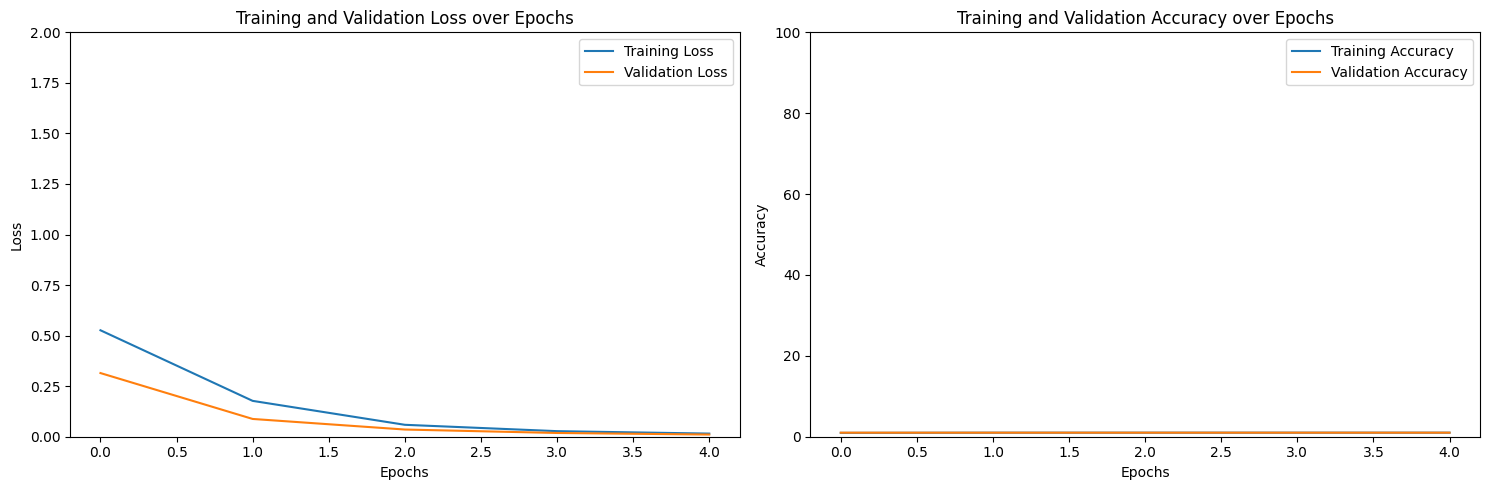

In [553]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_train_loss_plot, label='Training Loss')
axs[0].plot(total_validation_loss_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_train_acc_plot, label='Training Accuracy')
axs[1].plot(total_validation_acc_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()